# Оглавление
* [Описание проекта](#chapter1)
* * [Стоимость подержаного автомобиля](#chapter1.1)
* * [Основные этапы исследования](#chapter1.2)
* [Представление данных](#chapter2)
* [Предобработка данных](#chapter3)
* [Добавление синтетических данных](#chapter4)
* [Подбор и обучение моделей машинного обучения](#chapter5)
* * [Разбивка данных на признаки и таргет](#chapter5.1)
* * [Кодирование категориальных признаков](#chapter5.2)
* * [Нормализация данных](#chapter5.3)
* * [Обучение линейных моделей](#chapter5.4)
* * [Обучение модели случайного леса](#chapter5.5)
* [Выводы](#chapter6)

# Описание проекта <a name="chapter1"></a>

## Стоимость поддержанного автомобиля <a name="chapter1.1"></a>

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становится особо актуальным, если речь идет про дорогие товары, например про автомобили! В рамках данной задачи необходимо поработать с данными о продажах автомобилей на вторичном рынке. Целью данного проекта будет разработанная модель предсказания стоимости автомобиля на вторичном рынке.

## Основные этапы исследования <a name="chapter1.2"></a>

- Загрузка и ознакомление с данными, <p>
- Предварительная обработка,<p>
- Полноценный разведочный анализ,<p>
- Разработка новых синтетических признаков,<p>
- Проверка на мультиколлинеарность,<p>
- Отбор финального набора обучающих признаков,<p>
- Выбор и обучение моделей,<p>
- Итоговая оценка качества предсказания лучшей модели,<p>
- Анализ важности ее признаков.

# Представление данных  <a name="chapter2"></a>

In [144]:
# Установка необходимых расширений
!pip install imblearn

In [145]:
# Импорт основных библиотек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from pandas.api.types import is_string_dtype

from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

from imblearn.pipeline import Pipeline, make_pipeline

In [146]:
# Отключение лишних предупреждений
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [147]:
# Импорт датасета
try:
    sample_submission = pd.read_csv('datasets/sample_submission.csv')
    test = pd.read_csv('datasets/test.csv')
    train = pd.read_csv('datasets/train.csv')
except Exception as info:
    display(info)
    sample_submission = pd.read_csv('/kaggle/input/used-cars-price-prediction-19ds/sample_submission.csv')
    test = pd.read_csv('/kaggle/input/used-cars-price-prediction-19ds/test.csv')
    train = pd.read_csv('/kaggle/input/used-cars-price-prediction-19ds/train.csv')

In [148]:
# Объявим функцию для изучения датасетов
def describe_dataframe(dataframe):
    display(dataframe.head(10))
    display(dataframe.info())
    display(dataframe.describe(percentiles=[.5]).T)
    print(f"Количество дублированных строк: {dataframe.duplicated().sum()}")

In [149]:
describe_dataframe(train)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)
5,2013,Lincoln,MKZ,Base,Sedan,automatic,3ln6l2j91dr817800,mi,2.5,14894.0,black,black,"ford motor credit company,llc",22600,Thu May 21 2015 02:00:00 GMT-0700 (PDT)
6,2010,pontiac,g6,4c,NaN,automatic,1g2za5eb4a4157380,nc,3.4,114587.0,silver,black,north state acceptance,5900,Mon Jan 12 2015 09:30:00 GMT-0800 (PST)
7,2013,Ford,Escape,SE,SUV,automatic,1fmcu0gx3duc59421,fl,4.8,26273.0,blue,gray,fields bmw,15200,Tue Feb 03 2015 01:00:00 GMT-0800 (PST)
8,2000,Hyundai,Elantra,GLS,Sedan,automatic,kmhjf35f2yu955691,oh,1.9,182624.0,black,tan,dt inventory,700,Thu Jan 22 2015 01:00:00 GMT-0800 (PST)
9,2005,Ford,Freestyle,Limited,wagon,automatic,1fmdk06135ga45438,oh,1.0,149364.0,black,tan,wells fargo dealer services,325,Tue Jun 16 2015 05:00:00 GMT-0700 (PDT)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


None

,count,mean,std,min,50%,max
year,440236.0,2010.040101,3.977945,1982.0,2012.0,2015.0
condition,430831.0,3.425077,0.949973,1.0,3.6,5.0
odometer,440167.0,68344.421604,53542.203908,1.0,52098.0,999999.0
sellingprice,440236.0,13592.209588,9751.479098,1.0,12100.0,230000.0


Количество дублированных строк: 0


In [150]:
describe_dataframe(test)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)
5,2003,Volkswagen,Passat,GLS 1.8T,wagon,automatic,wvwvd63b93e175638,nc,2.4,104155.0,silver,black,fred anderson nissan of fayetteville,Tue Jun 09 2015 03:00:00 GMT-0700 (PDT)
6,2013,Hyundai,Sonata,GLS,Sedan,automatic,5npeb4ac4dh809686,il,3.7,30669.0,silver,gray,merchants leasing,Tue Mar 03 2015 02:00:00 GMT-0800 (PST)
7,2013,Ford,Explorer,Base,SUV,automatic,1fm5k7b97dgb16454,nc,3.2,87862.0,black,gray,ge fleet services for itself/servicer,Tue Feb 10 2015 01:15:00 GMT-0800 (PST)
8,2011,Infiniti,G Sedan,G37x,G Sedan,automatic,jn1cv6ar5bm411441,tn,3.5,47028.0,black,beige,nissan infiniti lt,Wed Feb 04 2015 02:30:00 GMT-0800 (PST)
9,2007,Chevrolet,Suburban,1500 LS,SUV,automatic,3gnfc16j77g158033,ga,3.4,191211.0,black,tan,riverside chevrolet inc,Tue Feb 10 2015 04:30:00 GMT-0800 (PST)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


None

,count,mean,std,min,50%,max
year,110058.0,2010.060005,3.960190,1982.0,2012.0,2015.0
condition,107679.0,3.423222,0.951301,1.0,3.6,5.0
odometer,110039.0,68074.331601,53520.988173,1.0,51922.0,999999.0


Количество дублированных строк: 0


In [151]:
# Рассмотрим корреляции численных данных
corr = train[['year', 'condition', 'odometer', 'sellingprice']].corr()
corr.style.background_gradient(cmap='coolwarm')

,year,condition,odometer,sellingprice
year,1.000000,0.553403,-0.774498,0.586847
condition,0.553403,1.000000,-0.540544,0.538906
odometer,-0.774498,-0.540544,1.000000,-0.583044
sellingprice,0.586847,0.538906,-0.583044,1.000000


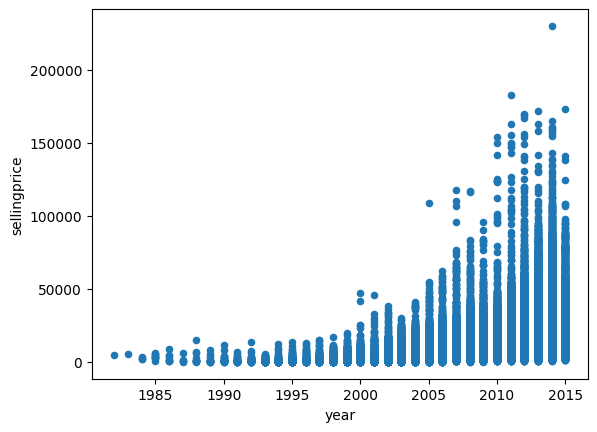

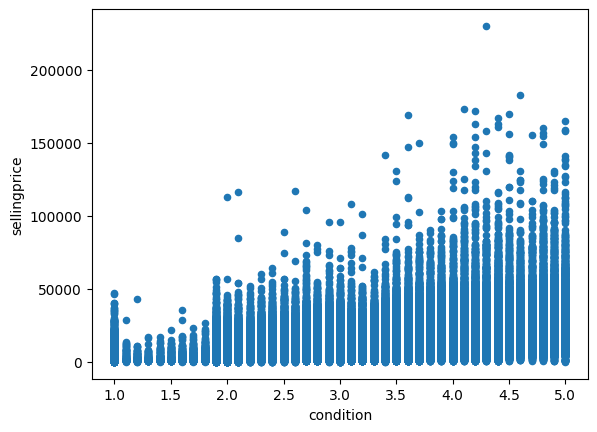

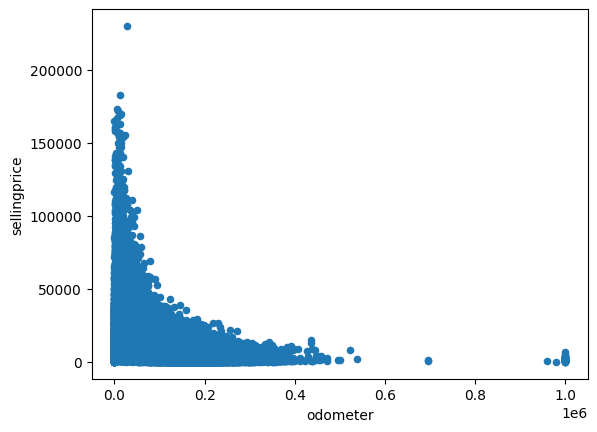

In [152]:
for idx, feature in enumerate(train[['year', 'condition', 'odometer']]):
    train.plot(feature, "sellingprice", subplots=True, kind="scatter")

Выводы: При знакомстве с данными были выявлены следующие особенности: В данных большое количество выбросов, пропущенных значений, неявных дубликатов в колонках с марками и моделями авто. В предобрабоке необходимо будет отсечь выбивающиеся значения и восстановить пропуски. Те строки, в которых данные восстановить невозможно - будут удалены, для уменьшения количества шумов в данных. Также числовые значения уже до кодирования категориальных переменных показывают, что данных мультиколлинеарным и линейные модели, скорее всего не подойдут для решения данной задачи.

# Предобработка данных <a name="chapter3"></a>

В процессе предобработки необходимо добиться следующих целей:
1) Выявить и устранить выбросы в колонках 'odometer' и 'sellingprice'
2) Привести колонку с датой продажи к виду datetime
3) С помощью группировок восполнить недостающие данные в категориальных ячейках
4) Если недостающие значение осталось - заменим его на other или unknown
5) Если недостающих значений слишком много - удалим строки полностю
6) Постараемся сохранить более 90% данных

In [153]:
# Сохраним первоначальные датафреймы для сравнения чистых и обработанных данных
raw_train = train.copy(deep=True)
raw_test = test.copy(deep=True)

In [154]:
# Определим крайние 2% значений одометра и будем считать, что это выбросы в данных
train['odometer'].quantile([0.01, 0.99])

0.01      3269.66
0.99    226987.68
Name: odometer, dtype: float64

In [155]:
# Удалим выбивающиеся значения из пробега и цены
train.drop(train.query("odometer > 227000 or odometer < 3270").index, inplace=True)

In [156]:
# Чтобы также сгладить предсказания теста - уберём выбивающиеся значения
# test.loc[test['odometer'] > 227000, 'odometer'] = 227000
# test.loc[test['odometer'] < 3270, 'odometer'] = 3270

In [157]:
# Определим крайние 3% значений цены авто и будем считать, что это выбросы в данных
train['sellingprice'].quantile([0.015, 0.985])

0.015      700.0
0.985    40500.0
Name: sellingprice, dtype: float64

In [158]:
train.drop(train.query("sellingprice > 40500 or sellingprice < 700").index, inplace=True)

In [159]:
# Все пропущенные значения на экране
train.isna().sum()

year                0
make             7063
model            7073
trim             7332
body             9095
transmission    48517
vin                 0
state               0
condition        8510
odometer           45
color             476
interior          476
seller              0
sellingprice        0
saledate            0
dtype: int64

In [160]:
# Преобразуем колонку с датой продажи к формату datetime
train['sellingprice'] = np.floor(pd.to_numeric(train['sellingprice'], errors='coerce')).astype('Int32')
train['condition'] = np.floor(pd.to_numeric(train['condition'], errors='coerce')).astype('Float64')

test['condition'] = np.floor(pd.to_numeric(test['condition'], errors='coerce')).astype('Float64')

train['saledate'] = pd.to_datetime(train['saledate'].str[:-15], format="%a %b %d %Y %H:%M:%S")
test['saledate'] = pd.to_datetime(test['saledate'].str[:-15], format="%a %b %d %Y %H:%M:%S")

In [161]:
# Изучим марки автомобилей
train['make'] = train['make'].str.capitalize()
display(f"Первоначальное число уникальных марок автомобилей: {train['make'].value_counts().count()}")
train['make'].value_counts()

'Первоначальное число уникальных марок автомобилей: 54'

Ford             71390
Chevrolet        45417
Nissan           41825
Toyota           30446
Dodge            23530
Honda            20584
Hyundai          16627
Bmw              14521
Kia              13978
Chrysler         13279
Mercedes-benz    12119
Infiniti         11837
Jeep             11727
Volkswagen        9606
Lexus             8909
Gmc               7896
Mazda             6475
Cadillac          5543
Acura             4507
Lincoln           4327
Audi              4197
Subaru            3906
Buick             3744
Ram               3275
Pontiac           3248
Mitsubishi        3217
Volvo             2772
Mini              2437
Saturn            1944
Mercury           1362
Scion             1320
Land rover        1091
Jaguar             936
Suzuki             794
Fiat               638
Hummer             591
Porsche            540
Saab               351
Smart              287
Oldsmobile         163
Isuzu              120
Mercedes            58
Maserati            54
Landrover  

In [162]:
# Напишем функцию для поиска и замены неявных дубликатов в марке авто
def make_unique(data):
    if not data or data in ['none', 'nan']:
        return 'Other'
    data = str(data)
    if data.find("ford") != -1:
        return "ford"
    elif data.find("gmc") != -1:
        return "gmc"
    elif data.find("land") != -1 and data.find("rover") != -1:
        return "landrover"
    elif data.find("mercedes") != -1:
        return "mercedes"
    elif data == "vw":
        return "volkswagen"
    elif data.find("dodge") != -1:
        return "dodge"
    elif data.find("mazda") != -1:  #  Hyundai
        return "mazda"
    elif data.find("hyundai") != -1:
        return "hyundai"
    else:
        return data

In [163]:
# Напишем функцию для поиска и замены неявных дубликатов в модели авто
def body_unique(data):
    if not data or data in ['none', 'nan']:
        return 'Other'
    data = str(data)
    if data.find("cab") != -1 or data.find("crew") != -1:
        return "pick-up"
    if data.find("convertible") != -1:
        return "convertible"
    if data.find("coupe") != -1 or data.find("koup") != -1:
        return "coupe"
    if data.find("wagon") != -1:
        return "wagon"
    if data.find("van") != -1:
        return "van"
    if data.find("sedan") != -1:
        return "sedan"
    else:
        return data

In [164]:
# Устраняем неявные дубликаты марок авто в трейне
train['make'] = train['make'].str.lower().apply(make_unique).str.capitalize()
train['make'].value_counts()

Ford            71391
Chevrolet       45417
Nissan          41825
Toyota          30446
Dodge           23530
Honda           20584
Hyundai         16627
Bmw             14521
Kia             13978
Chrysler        13279
Mercedes        12179
Infiniti        11837
Jeep            11727
Volkswagen       9622
Lexus            8909
Gmc              7906
Nan              7063
Mazda            6476
Cadillac         5543
Acura            4507
Lincoln          4327
Audi             4197
Subaru           3906
Buick            3744
Ram              3275
Pontiac          3248
Mitsubishi       3217
Volvo            2772
Mini             2437
Saturn           1944
Mercury          1362
Scion            1320
Landrover        1110
Jaguar            936
Suzuki            794
Fiat              638
Hummer            591
Porsche           540
Saab              351
Smart             287
Oldsmobile        163
Isuzu             120
Maserati           54
Plymouth           11
Bentley             4
Geo       

In [165]:
# Находим пустые значения марок авто
train.loc[train['make'] == 'Nan', 'make'] = np.nan
train[train.make.isna()]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
10,2007,NaN,NaN,NaN,NaN,automatic,5tfbv54157x019560,ca,3.0,102507.0,blue,gray,aaero sweet company,17250,2015-01-29 03:30:00
42,2007,NaN,NaN,NaN,NaN,manual,jm1bk34l671745431,md,2.0,92656.0,blue,gray,credit acceptance corp/vrs/southfield,5600,2015-06-16 02:30:00
63,2011,NaN,NaN,NaN,NaN,automatic,1fdne1bw5bda64735,ga,5.0,67159.0,white,gray,"vpsi, inc",13200,2015-06-04 03:00:00
64,2008,NaN,NaN,NaN,NaN,automatic,1gbdv13wx8d142776,ca,4.0,113582.0,white,gray,wholesale motor sales inc,4100,2015-02-05 04:00:00
111,2006,NaN,NaN,NaN,NaN,automatic,3gnda13d36s611801,nv,2.0,129019.0,orange,gray,credit acceptance corp/vrs/southfield,2900,2015-02-05 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440085,2011,NaN,NaN,NaN,NaN,automatic,1fdne1bw8bdb21610,az,3.0,80594.0,white,gray,mike albert fleet solutions,11100,2015-02-04 03:00:00
440114,2011,NaN,NaN,NaN,NaN,automatic,2lnbl8ev9bx757689,nj,3.0,134164.0,—,black,merchants automotive group,11800,2015-03-04 01:30:00
440118,2004,NaN,NaN,NaN,NaN,automatic,1gyde637240130408,md,3.0,123123.0,white,beige,credit acceptance corp/vrs/southfield,3400,2015-02-17 01:30:00
440122,2007,NaN,NaN,NaN,NaN,automatic,salme15487a251642,ca,2.0,39545.0,black,black,hornburg jaguar,17750,2015-06-17 05:15:00


In [166]:
# Т.к все эти 7063 значений пустые - они создатут лишний шум в предсказаниях - удалим их
train.dropna(subset=['make', 'model'], inplace=True)

In [167]:
# Устраняем неявные дубликаты марок авто в тесте
test['make'] = test['make'].str.lower().apply(make_unique).str.capitalize()
test['make'].value_counts()

Ford            18466
Chevrolet       11801
Nissan          10485
Toyota           7728
Dodge            6188
Honda            5382
Hyundai          4410
Bmw              4136
Kia              3571
Mercedes         3471
Chrysler         3459
Jeep             3069
Infiniti         3002
Volkswagen       2515
Lexus            2430
Nan              2061
Gmc              2059
Mazda            1676
Cadillac         1496
Lincoln          1153
Acura            1151
Audi             1124
Buick            1019
Subaru           1015
Ram               889
Pontiac           866
Mitsubishi        806
Volvo             765
Mini              674
Saturn            544
Mercury           434
Landrover         371
Scion             318
Jaguar            297
Porsche           280
Suzuki            222
Fiat              181
Hummer            174
Saab               93
Oldsmobile         88
Smart              81
Isuzu              38
Bentley            23
Maserati           21
Tesla               6
Plymouth  

In [168]:
# Устраняем неявные дубликаты моделей авто в трейне
train.loc[train['body'] == 'Nan', 'body'] = np.nan
train['body'] = train['body'].str.lower().apply(body_unique).str.capitalize()
train['body'] = train['body'].str.lower().apply(body_unique).str.capitalize()
train['body'].value_counts()

Sedan          188143
Suv            108002
Pick-up         35205
Van             24096
Hatchback       20015
Coupe           14331
Wagon           12192
Convertible      7630
Other            2032
Name: body, dtype: int64

In [169]:
# Устраняем неявные дубликаты моделей авто в тесте
test['body'] = test['body'].str.lower().apply(body_unique).str.capitalize()
test['body'] = test['body'].str.lower().apply(body_unique).str.capitalize()
test['body'].value_counts()

Sedan          48970
Suv            28295
Pick-up         9202
Van             6414
Hatchback       5152
Coupe           3995
Wagon           3287
Other           2594
Convertible     2149
Name: body, dtype: int64

In [170]:
# Для упрощения исследования данных заменим оставшиеся значения на unknown
train['model'] = train['model'].str.capitalize()
train['model'].fillna("Unknown", inplace=True)
train['model'].value_counts()

Altima       15156
F-150        10996
Fusion       10178
Camry         9636
Escape        9358
             ...  
42c              1
Gla-class        1
Swift            1
420-class        1
G500             1
Name: model, Length: 780, dtype: int64

In [171]:
# Для упрощения исследования данных заменим оставшиеся значения на unknown
test['model'] = test['model'].str.capitalize()
test['model'].fillna("Unknown", inplace=True)
test['model'].value_counts()

Altima           3736
F-150            2737
Fusion           2553
Camry            2423
Escape           2296
                 ... 
Exige               1
1                   1
C240w               1
Accord hybrid       1
Caprice             1
Name: model, Length: 747, dtype: int64

In [172]:
train['trim'] = train['trim'].str.capitalize()
train['trim'].fillna("Unknown", inplace=True)
train['trim'].value_counts()

Base                40852
Se                  33548
Lx                  15772
Limited             14111
Lt                  12946
                    ...  
4x2 ex xl               1
4x2 v8 xlt              1
10th anniversary        1
Se premium              1
4x4 v6 xlt sport        1
Name: trim, Length: 1719, dtype: int64

In [173]:
test['trim'] = test['trim'].str.capitalize()
test['trim'].fillna("Unknown", inplace=True)
test['trim'].value_counts()

Base                11009
Se                   8725
Lx                   4098
Limited              3536
Lt                   3280
                    ...  
4wd s                   1
Hx                      1
Gr tr gr touring        1
Mr touring              1
Awd xs ll bean          1
Name: trim, Length: 1458, dtype: int64

In [174]:
train['transmission'].value_counts()

automatic    352103
manual        12263
Name: transmission, dtype: int64

In [175]:
# В трансмиссии слишком много пропущенных значений, поэтому постараемся с помощью группировки значенией найти утраченные данные. Оставшиеся заменим на Unknown
train['transmission'].fillna(
    train.groupby(['make', 'model'])['transmission'].transform(
        lambda x: x.fillna(x.iloc[round(len(x) / 2)])
    ),
    inplace=True
)  # Думаю, что это можно удалить
train['transmission'].fillna("Unknown", inplace=True)
train['transmission'].value_counts()

automatic    390857
manual        14376
Unknown        6413
Name: transmission, dtype: int64

In [176]:
test['transmission'].value_counts()

automatic    93584
manual        3463
Name: transmission, dtype: int64

In [177]:
#  Повторим процедуру для теста, но на основании данных ТРЕЙНА
test['transmission'].fillna(
    train.groupby(['make', 'model'])['transmission'].transform(
        lambda x: x.fillna(x.iloc[round(len(x) / 2)])
    ),
    inplace=True
)
test['transmission'].fillna("Unknown", inplace=True)
test['transmission'].value_counts()

automatic    105196
manual         3867
Unknown         995
Name: transmission, dtype: int64

In [178]:
#  Пропущенные значения в цвете заменим на прочерк - он мало влияет на цену авто
train['color'].fillna("—", inplace=True)
train['color'].value_counts()

black        81395
white        78034
gray         62250
silver       61948
blue         37675
red          32300
—            19075
gold          7973
green         7662
burgundy      6603
beige         6573
brown         4994
orange        1505
purple        1126
off-white     1091
yellow         868
charcoal       366
turquoise      166
pink            28
lime            14
Name: color, dtype: int64

In [179]:
test['color'].fillna("—", inplace=True)
test['color'].value_counts()

black        22006
white        20928
silver       16360
gray         16348
blue         10180
red           8384
—             5106
green         2270
gold          2207
beige         1826
burgundy      1759
brown         1300
orange         407
purple         284
off-white      275
yellow         274
charcoal        84
turquoise       49
pink            10
lime             1
Name: color, dtype: int64

In [180]:
#  Пропущенные значения в интерьере заменим на прочерк - он мало влияет на цену авто
train['interior'].fillna("—", inplace=True)
train['interior'].value_counts()

black        182809
gray         131234
beige         43706
tan           31878
—             12253
brown          5995
red             892
silver          798
blue            646
off-white       358
purple          240
gold            234
white           195
green           172
burgundy        130
orange           93
yellow           13
Name: interior, dtype: int64

In [181]:
test['interior'].fillna("—", inplace=True)
test['interior'].value_counts()

black        48176
gray         34984
beige        11931
tan           8658
—             3538
brown         1664
red            264
blue           241
silver         225
off-white      107
gold            64
purple          58
green           44
burgundy        34
orange          33
white           33
yellow           4
Name: interior, dtype: int64

In [182]:
#  Постараемся максимально точно оценить состояние авто, т.к. от него зависит большая часть ценв автомобиля
train['condition'].fillna(train.groupby(['make', 'body', 'trim', 'model'])['condition'].transform('median'), inplace=True)
train['condition'].fillna(train.groupby(['make'])['condition'].transform('median'), inplace=True)
train['condition'] = np.round(train['condition'], decimals = 1)
train['condition'].value_counts()

4.0    135095
3.0    135008
2.0    100262
1.0     33950
5.0      7164
2.5        90
1.5        63
3.5        14
Name: condition, dtype: Int64

In [183]:
test['condition'].fillna(train.groupby(['make', 'body', 'trim', 'model'])['condition'].transform('median'), inplace=True)
test['condition'].fillna(train.groupby(['make'])['condition'].transform('median'), inplace=True)
test['condition'].fillna(train['condition'].median(), inplace=True)

In [184]:
test['condition'].value_counts()

4.0    35805
3.0    35337
2.0    26526
1.0    10153
5.0     2218
2.5        9
3.5        7
1.5        3
Name: condition, dtype: Int64

In [185]:
#  Показания одометра не менее важны, чем состояние автомобиля
train['odometer'].fillna(train.groupby(['make', 'body', 'model'])['odometer'].transform('mean'), inplace=True)

In [186]:
test['odometer'].fillna(train.groupby(['make', 'body', 'model'])['odometer'].transform('mean'), inplace=True)
test['odometer'].fillna(train['odometer'].mean(), inplace=True)

In [187]:
train.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
dtype: int64

In [188]:
test.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
saledate        0
dtype: int64

In [189]:
#  Посчитаем итоговую потерю в данных, оно не должно составить более 10% от общего значения
train_losses = abs(train.shape[0] - raw_train.shape[0]) / raw_train.shape[0] * 100
display(f"Общие потери данных в процентах: {train_losses}%")

'Общие потери данных в процентах: 6.49424399640193%'

Выводы: В итоге предобработки данных были устранены все пропущенные значения, явные выбросы и форматы некоторых колонок. Итоговая потеря данных составила около 7%, что не повредит дальнейшей работе.

# Добавление синтетических данных <a name="chapter4"></a>

В исходном датафреме есть колонка - saledate, которая сама по себе не несёт полезной информации для модели. Однако, её можно разбить на такие составляющие как:
1) Год продажи
2) Месяц продажи
3) День недели продажи
Также исходя из этой даты можно высчитать суммарный возраст автомобиля.
После преобразований данную колонку стоит удалить за ненадобностью. Колонки VIN и SELLER также подлежат удалению.

In [190]:
#  Добавим колонки, связанные с датой продажи
train['saledate_week_day'] = train['saledate'].dt.weekday
train['saledate_month'] = train['saledate'].dt.month
train['saledate_year'] = train['saledate'].dt.year
train['car_age'] = train['saledate'].dt.year - train['year']

In [191]:
# Проявились стодцы с отрицательным возрастом - заменим возраст на нулевой и уменьшим год создания авто.
# train.loc[train["car_age"] < 0, "year"] -= int(train["car_age"])
train.loc[train["car_age"] < 0, "car_age"] = 0

In [192]:
test['saledate_week_day'] = test['saledate'].dt.weekday
test['saledate_month'] = test['saledate'].dt.month
test['saledate_year'] = test['saledate'].dt.year
test['car_age'] = test['saledate'].dt.year - test['year']

In [193]:
train.drop(columns=[
    'vin',
    'seller',
    'saledate'
], inplace=True)

In [194]:
test.drop(columns=[
    'vin',
    'seller',
    'saledate'
], inplace=True)

In [195]:
#  Проверим корреляции получившихся столбцов
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\APMuravev\AppData\Local\Temp\ipykernel_47984\1228014876.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


,year,condition,odometer,sellingprice,saledate_week_day,saledate_month,saledate_year,car_age
year,1.000000,0.508836,-0.799027,0.623031,0.037312,-0.050652,0.118899,-0.996742
condition,0.508836,1.000000,-0.520901,0.536352,0.040975,-0.041923,0.058489,-0.507351
odometer,-0.799027,-0.520901,1.000000,-0.637667,-0.067362,0.047124,-0.092129,0.796649
sellingprice,0.623031,0.536352,-0.637667,1.000000,0.084993,-0.043435,0.086422,-0.619999
saledate_week_day,0.037312,0.040975,-0.067362,0.084993,1.000000,-0.009910,0.033663,-0.034849
saledate_month,-0.050652,-0.041923,0.047124,-0.043435,-0.009910,1.000000,-0.824143,-0.015870
saledate_year,0.118899,0.058489,-0.092129,0.086422,0.033663,-0.824143,1.000000,-0.038566
car_age,-0.996742,-0.507351,0.796649,-0.619999,-0.034849,-0.015870,-0.038566,1.000000


В данном подпункте были добавлены 4 столбцов в синтетическими данными - год, месяц и день недели продажи авто. Также полный возраст авто, устранены аномалии в возрасте авто. Доказана мультиколлинеарность данных.

# Подбор и обучение моделей машинного обучения <a name="chapter5"></a>

Для решения задачи обучения оптимальной модели потребуется:
1) выполнить кодирование категориальных значений
2) произвести уравнивание (скейлинг) данных
3) подобрать оптимальные гиперпараметры модели
4) произвести кроссвалидацию модели

Для решения задачи регрессии достаточно порядково кодировать категориальные переменные, для этого необходим OrdinalEncoder.
Для уравнивания данных используем StandardScaler.
Чтобы обучить оптимальную модель, следует подобрать её параметры. Для такого большого датафрейма подойдет  RandomizedSearchCV ввиду быстроты выполнения.

## Разбивка данных на признаки и таргет <a name="chapter5.1"></a>

In [196]:
# Разобьём данные трейна на таргет и данные для обучения
target_train = train['sellingprice']
features_train = train.drop(['sellingprice'], axis=1)

In [197]:
features_test = test

In [198]:
# Выявим количественные и категориальные колонки
categorical_columns = list(filter(lambda column: is_string_dtype(features_train[column]), features_train.columns))
numeric_columns = list(filter(lambda column: not is_string_dtype(features_train[column]), features_train.columns))

In [199]:
categorical_columns

['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior']

## Кодирование категориальных столбцов <a name="chapter5.2"></a>

In [200]:
# Создадим и обучим на трейне декодер. Неизвестные категориальные значения из теста будем менять на -1
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(features_train[categorical_columns])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [201]:
#  Кодируем трейн
features_train_encoded = pd.DataFrame(
    encoder.transform(features_train[categorical_columns]), # .toarray()
    columns=encoder.get_feature_names_out(categorical_columns),
    index=features_train.index
)
features_train_encoded.shape

(411646, 8)

In [202]:
features_train_encoded = pd.concat((features_train[numeric_columns], features_train_encoded), axis=1)
features_train_encoded.shape

(411646, 15)

In [203]:
features_train_encoded.head()

,year,condition,odometer,saledate_week_day,saledate_month,saledate_year,car_age,make,model,trim,body,transmission,state,color,interior
0,2011,4.0,111041.0,1,6,2015,4,12.0,227.0,1312.0,6.0,1.0,12.0,1.0,1.0
1,2014,3.0,31034.0,2,2,2015,1,12.0,301.0,1282.0,5.0,1.0,15.0,1.0,1.0
2,2012,2.0,35619.0,2,6,2015,3,32.0,618.0,67.0,5.0,1.0,19.0,1.0,1.0
3,2003,2.0,131301.0,2,6,2015,12,16.0,357.0,546.0,6.0,1.0,33.0,6.0,0.0
4,2007,2.0,127709.0,1,2,2015,8,12.0,301.0,1312.0,5.0,1.0,12.0,1.0,1.0


In [204]:
#  Кодируем тест
features_test_encoded = pd.DataFrame(
    encoder.transform(features_test[categorical_columns]), # .toarray()
    columns=encoder.get_feature_names_out(categorical_columns),
    index=features_test.index
)
features_test_encoded = pd.concat((features_test[numeric_columns], features_test_encoded), axis=1)

In [205]:
describe_dataframe(features_test_encoded)

,year,condition,odometer,saledate_week_day,saledate_month,saledate_year,car_age,make,model,trim,body,transmission,state,color,interior
0,2005,2.0,116970.0,2,1,2015,10,6.0,191.0,546.0,5.0,1.0,3.0,15.0,1.0
1,2014,4.0,6286.0,4,2,2015,1,14.0,612.0,172.0,7.0,1.0,28.0,17.0,6.0
2,2013,4.0,11831.0,1,2,2015,2,32.0,479.0,1233.0,6.0,1.0,24.0,7.0,1.0
3,2013,2.0,57105.0,4,3,2015,2,7.0,370.0,1040.0,5.0,1.0,5.0,15.0,1.0
4,2013,2.0,31083.0,2,6,2015,2,32.0,688.0,1451.0,4.0,1.0,32.0,1.0,1.0
5,2003,2.0,104155.0,1,6,2015,12,45.0,504.0,880.0,8.0,1.0,17.0,15.0,1.0
6,2013,3.0,30669.0,1,3,2015,2,17.0,650.0,878.0,5.0,1.0,8.0,15.0,6.0
7,2013,3.0,87862.0,1,2,2015,2,12.0,270.0,546.0,6.0,1.0,17.0,1.0,6.0
8,2011,3.0,47028.0,2,2,2015,4,18.0,310.0,851.0,5.0,1.0,32.0,1.0,0.0
9,2007,3.0,191211.0,1,2,2015,8,7.0,670.0,45.0,6.0,1.0,6.0,1.0,13.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   year               110058 non-null  int64  
 1   condition          110058 non-null  Float64
 2   odometer           110058 non-null  float64
 3   saledate_week_day  110058 non-null  int64  
 4   saledate_month     110058 non-null  int64  
 5   saledate_year      110058 non-null  int64  
 6   car_age            110058 non-null  int64  
 7   make               110058 non-null  float64
 8   model              110058 non-null  float64
 9   trim               110058 non-null  float64
 10  body               110058 non-null  float64
 11  transmission       110058 non-null  float64
 12  state              110058 non-null  float64
 13  color              110058 non-null  float64
 14  interior           110058 non-null  float64
dtypes: Float64(1), float64(9), int64(5)
memory usage: 1

None

,count,mean,std,min,50%,max
year,110058.0,2010.060005,3.96019,1982.0,2012.0,2015.0
condition,110058.0,2.940063,1.00622,1.0,3.0,5.0
odometer,110058.0,68074.667943,53517.4034,1.0,51932.5,999999.0
saledate_week_day,110058.0,2.14287,1.044089,0.0,2.0,6.0
saledate_month,110058.0,3.810518,3.241834,1.0,2.0,12.0
saledate_year,110058.0,2014.902751,0.296297,2014.0,2015.0,2015.0
car_age,110058.0,4.842747,3.938529,-1.0,3.0,33.0
make,110058.0,19.089698,12.832398,-1.0,15.0,46.0
model,110058.0,346.039425,218.513467,-1.0,301.0,779.0
trim,110058.0,969.906604,448.410963,-1.0,1034.0,1718.0


Количество дублированных строк: 0


## Нормализация данных <a name="chapter5.3"></a>

In [206]:
# Создадим и обучим скейлер
scaler = StandardScaler()
scaler.fit(features_train_encoded)

StandardScaler()

In [207]:
# Проводим скейлинг трейна
features_train_scaled = pd.DataFrame(
    scaler.transform(features_train_encoded),
    columns=features_train_encoded.columns,
    index=features_train_encoded.index)
describe_dataframe(features_train_scaled)

,year,condition,odometer,saledate_week_day,saledate_month,saledate_year,car_age,make,model,trim,body,transmission,state,color,interior
0,0.200119,1.062134,0.960983,-1.094389,0.674607,0.32821,-0.174802,-0.595481,-0.587020,0.781260,0.658855,-0.0864,-0.362034,-1.264381,-0.700759
1,1.018457,0.046558,-0.732301,-0.136983,-0.558425,0.32821,-0.998474,-0.595481,-0.241758,0.714154,0.003214,-0.0864,-0.101903,-1.264381,-0.700759
2,0.472898,-0.969018,-0.635263,-0.136983,0.674607,0.32821,-0.449360,0.983567,1.237268,-2.003653,0.003214,-0.0864,0.244939,-1.264381,-0.700759
3,-1.982116,-0.969018,1.389770,-0.136983,0.674607,0.32821,2.021654,-0.279671,0.019521,-0.932189,0.658855,-0.0864,1.458887,-0.513218,-0.937280
4,-0.890999,-0.969018,1.313748,-1.094389,-0.558425,0.32821,0.923426,-0.595481,-0.241758,0.781260,0.003214,-0.0864,-0.362034,-1.264381,-0.700759
5,0.745677,-0.969018,-1.073891,0.820423,0.366349,0.32821,-0.723917,0.430900,0.523416,-0.932189,0.003214,-0.0864,-0.275324,-1.264381,-0.700759
6,-0.072661,0.046558,1.036032,-2.051795,-0.866683,0.32821,0.099755,1.220424,-0.134447,-1.431013,-1.308067,-0.0864,0.071518,0.838877,-0.700759
7,0.745677,1.062134,-0.833064,-1.094389,-0.558425,0.32821,-0.723917,-0.595481,-0.447049,0.714154,0.658855,-0.0864,-0.969008,-1.114149,0.481847
8,-2.800454,-1.984595,2.475981,0.820423,-0.866683,0.32821,2.845326,-0.200719,-0.568357,-0.189545,0.003214,-0.0864,0.678492,-1.264381,2.137497
11,0.200119,1.062134,0.193125,-0.136983,-0.866683,0.32821,-0.174802,-1.148147,0.308794,-0.623500,0.003214,-0.0864,-0.101903,1.139342,2.137497


<class 'pandas.core.frame.DataFrame'>
Int64Index: 411646 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   year               411646 non-null  float64
 1   condition          411646 non-null  float64
 2   odometer           411646 non-null  float64
 3   saledate_week_day  411646 non-null  float64
 4   saledate_month     411646 non-null  float64
 5   saledate_year      411646 non-null  float64
 6   car_age            411646 non-null  float64
 7   make               411646 non-null  float64
 8   model              411646 non-null  float64
 9   trim               411646 non-null  float64
 10  body               411646 non-null  float64
 11  transmission       411646 non-null  float64
 12  state              411646 non-null  float64
 13  color              411646 non-null  float64
 14  interior           411646 non-null  float64
dtypes: float64(15)
memory usage: 66.4 MB


None

,count,mean,std,min,50%,max
year,411646.0,-1.491239e-15,1.000001,-7.164924,0.472898,1.291236
condition,411646.0,8.198982e-17,1.000001,-1.984595,0.046558,2.077711
odometer,411646.0,-1.680878e-16,1.000001,-1.319904,-0.303377,3.414973
saledate_week_day,411646.0,2.057340e-16,1.000001,-2.051795,-0.136983,3.692641
saledate_month,411646.0,-1.429212e-17,1.000001,-0.866683,-0.558425,2.524155
saledate_year,411646.0,4.503160e-14,1.000001,-3.046831,0.328210,0.328210
car_age,411646.0,-8.371592e-18,1.000001,-1.273031,-0.449360,7.238239
make,411646.0,1.167190e-16,1.000001,-1.542909,-0.358624,2.088900
model,411646.0,1.209307e-16,1.000001,-1.646132,-0.204432,1.988445
trim,411646.0,-6.250213e-17,1.000001,-2.153524,0.159408,1.689433


Количество дублированных строк: 0


In [208]:
# Проводим скейлинг теста
features_test_scaled = pd.DataFrame(
    scaler.transform(features_test_encoded),
    columns=features_test_encoded.columns,
    index=features_test_encoded.index)
describe_dataframe(features_test_scaled)

,year,condition,odometer,saledate_week_day,saledate_month,saledate_year,car_age,make,model,trim,body,transmission,state,color,interior
0,-1.436558,-0.969018,1.086466,-0.136983,-0.866683,0.32821,1.472540,-1.069195,-0.754985,-0.932189,0.003214,-0.0864,-1.142429,0.838877,-0.700759
1,1.018457,1.062134,-1.256073,1.777829,-0.558425,0.32821,-0.998474,-0.437576,1.209273,-1.768781,1.314495,-0.0864,1.025334,1.139342,0.481847
2,0.745677,1.062134,-1.138717,-1.094389,-0.558425,0.32821,-0.723917,0.983567,0.588736,0.604547,0.658855,-0.0864,0.678492,-0.362985,-0.700759
3,0.745677,-0.969018,-0.180529,1.777829,-0.250167,0.32821,-0.723917,-0.990243,0.080175,0.172829,0.003214,-0.0864,-0.969008,0.838877,-0.700759
4,0.745677,-0.969018,-0.731264,-0.136983,0.674607,0.32821,-0.723917,0.983567,1.563866,1.092186,-0.652426,-0.0864,1.372176,-1.264381,-0.700759
5,-1.982116,-0.969018,0.815247,-1.094389,0.674607,0.32821,2.021654,2.009948,0.705378,-0.185071,1.970136,-0.0864,0.071518,0.838877,-0.700759
6,0.745677,0.046558,-0.740026,-1.094389,-0.250167,0.32821,-0.723917,-0.200719,1.386570,-0.189545,0.003214,-0.0864,-0.708876,0.838877,0.481847
7,0.745677,0.046558,0.470418,-1.094389,-0.558425,0.32821,-0.723917,-0.595481,-0.386395,-0.932189,0.658855,-0.0864,0.071518,-1.264381,0.481847
8,0.200119,0.046558,-0.393801,-0.136983,-0.558425,0.32821,-0.174802,-0.121766,-0.199767,-0.249941,0.003214,-0.0864,1.372176,-1.264381,-0.937280
9,-0.890999,0.046558,2.657718,-1.094389,-0.558425,0.32821,0.923426,-0.990243,1.479884,-2.052865,0.658855,-0.0864,-0.882297,-1.264381,2.137497


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   year               110058 non-null  float64
 1   condition          110058 non-null  float64
 2   odometer           110058 non-null  float64
 3   saledate_week_day  110058 non-null  float64
 4   saledate_month     110058 non-null  float64
 5   saledate_year      110058 non-null  float64
 6   car_age            110058 non-null  float64
 7   make               110058 non-null  float64
 8   model              110058 non-null  float64
 9   trim               110058 non-null  float64
 10  body               110058 non-null  float64
 11  transmission       110058 non-null  float64
 12  state              110058 non-null  float64
 13  color              110058 non-null  float64
 14  interior           110058 non-null  float64
dtypes: float64(15)
memory usage: 12.6 MB


None

,count,mean,std,min,50%,max
year,110058.0,-0.056293,1.080258,-7.710482,0.472898,1.291236
condition,110058.0,-0.014312,1.021893,-1.984595,0.046558,2.077711
odometer,110058.0,0.051635,1.132653,-1.389090,-0.290001,19.775073
saledate_week_day,110058.0,-0.000198,0.999617,-2.051795,-0.136983,3.692641
saledate_month,110058.0,-0.000319,0.999321,-0.866683,-0.558425,2.524155
saledate_year,110058.0,-0.000009,1.000016,-3.046831,0.328210,0.328210
car_age,110058.0,0.056580,1.081351,-1.547588,-0.449360,7.787354
make,110058.0,-0.035732,1.013148,-1.621862,-0.358624,2.088900
model,110058.0,-0.031618,1.019517,-1.650798,-0.241758,1.988445
trim,110058.0,0.016039,1.003041,-2.155761,0.159408,1.689433


Количество дублированных строк: 0


## Обучение линейных моделей <a name="chapter5.4"></a>

In [209]:
from sklearn.linear_model import LinearRegression

lin_regressor = LinearRegression()
lin_regressor.fit(features_train_scaled, target_train)

list(zip(features_train_scaled.columns, lin_regressor.coef_))

[('year', 1698.6088039350423),
 ('condition', 1970.9439246501756),
 ('odometer', -2554.060771798476),
 ('saledate_week_day', 332.73353592872667),
 ('saledate_month', 133.477339913992),
 ('saledate_year', 226.74419267429613),
 ('car_age', -253.50106090976396),
 ('make', -563.5023917973422),
 ('model', 356.9311727714638),
 ('trim', -2.5640556578267137),
 ('body', -14.910505283811787),
 ('transmission', -234.12090540288708),
 ('state', -16.571488994692714),
 ('color', -188.25417530887617),
 ('interior', -85.10426776132988)]

In [210]:
submission = lin_regressor.predict(features_test_scaled)
sample_submission['sellingprice'] = submission
sample_submission.to_csv('sample_submission.csv', index=False)

Видно, что данные не сбалансированы и вес некоторых категорий критично выше других. Следует применить линейные модели сбалансировав классы.
MAPE предсказаний данной модели = 67.87, что является плохим результатом.

In [211]:
from sklearn.linear_model import Lasso

lasso_regressor = Lasso()
lasso_regressor.fit(features_train_scaled, target_train)

list(zip(features_train_scaled.columns, lasso_regressor.coef_))

C:\Users\APMuravev\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.934e+10, tolerance: 2.686e+09
  model = cd_fast.enet_coordinate_descent(


[('year', 3027.85649435814),
 ('condition', 1970.1925595627208),
 ('odometer', -2553.831936533952),
 ('saledate_week_day', 331.87158939738003),
 ('saledate_month', 127.56644320921284),
 ('saledate_year', 113.89957139087156),
 ('car_age', 1065.3544374803616),
 ('make', -562.2719243528785),
 ('model', 355.51633238393157),
 ('trim', -1.5249901704266196),
 ('body', -13.68894197758514),
 ('transmission', -232.83425450213466),
 ('state', -15.463751712850652),
 ('color', -187.34702069774573),
 ('interior', -84.06511673666151)]

In [212]:
submission = lasso_regressor.predict(features_test_scaled)
sample_submission['sellingprice'] = submission
sample_submission.to_csv('sample_submission.csv', index=False)

После регуляризации результат не сильно изменился.
MAPE предсказаний данной модели = 67.87, что не отличается от предыдущей модели.
Следовательно, стоит обучить более тяжелую модель для более точных предсказаний.

## Обучение модели случайного леса <a name="chapter5.5"></a>

In [213]:
# Для одинакового результата создадим фолды для трейна
kf = KFold(n_splits=3, random_state=32123, shuffle=True)

In [214]:
# Определим сетку параметров для поиска оптимальной комбинации
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5, 10, 15, 20],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4]
}

In [215]:
pipeline = make_pipeline(
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    StandardScaler(),
    RandomForestRegressor())

In [216]:
# найдём параметры для оптимальной модели случайного леса
from sklearn.model_selection import RandomizedSearchCV

rf_params = {'randomforestregressor__' + key: param_grid[key] for key in param_grid}
grid_rf = RandomizedSearchCV(
    pipeline, # RandomForestRegressor()
    param_distributions=rf_params,
    cv=kf,
    n_iter=15,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=2,
    return_train_score=True)

In [217]:
# Обучаем сетки и выводим наилучшие параметры
grid_rf.fit(features_train, target_train)
grid_rf.best_params_

{'randomforestregressor__n_estimators': 500,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__min_samples_leaf': 4,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__max_depth': 20}

In [218]:
# Наилучшая оценка
grid_rf.best_score_

-0.3909180588263725

Получаем ожидаемую оценку в полтора раза лучше, чем при обучении линейной модели.

In [225]:
# Обучаем оптиальную модель
model = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features='sqrt',
    max_depth=20)
# model.fit(features_train, target_train)

In [226]:
rf_pipeline = make_pipeline(
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    StandardScaler(),
    model)

In [227]:
rf_pipeline.fit(features_train, target_train)

C:\Users\APMuravev\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=20, max_features='auto',
                                       min_samples_split=5,
                                       n_estimators=200))])

In [228]:
# Находим предсказание
submission = rf_pipeline.predict(features_test)
submission

array([ 3460.1900058 , 22318.59177325, 17901.64329955, ...,
        3409.16569242, 18529.15714286, 16459.30823797])

In [229]:
# Заполняем sample_submission
sample_submission['sellingprice'] = submission
sample_submission.to_csv('sample_submission.csv', index=False)

# Выводы <a name="chapter6"></a>

Выводы:
В рамках данной задачи необходимо поработать с данными о продажах автомобилей на вторичном рынке. В данном проекте была разработана модель предсказания стоимости автомобиля на вторичном рынке.
При знакомстве с данными были выявлены следующие особенности: В данных большое количество выбросов, пропущенных значений, неявных дубликатов в колонках с марками и моделями авто.
В итоге предобработки данных были устранены все пропущенные значения, явные выбросы и форматы некоторых колонок. Итоговая потеря данных составила около 7%.
Далее были добавлены 4 синтетических столбца - год, месяц и день недели продажи авто. Также полный возраст авто, устранены аномалии в возрасте авто. Доказана мультиколлинеарность данных.
Данные были кодированы, проведём скейлинг, почле чего с помощью RandomizedSearchCV были подобраны оптимальные параметры модели с MAPE = 16% (Итоговая MAPE на тестовых данных = 23%). Модель имела следующие параметры:
<code>RandomForestRegressor(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='auto',
    max_depth=20)</code>
